# Using Light Curve Files with Lightkurve

## Learning Goals

By the end of this tutorial, you will:

- Understand how NASA's *Kepler* Mission collected and released light curve data products.
- Be able to download and plot light curve files from the data archive using [Lightkurve](https://docs.lightkurve.org).
- Be able to access light curve metadata.
- Understand the time and brightness units.

## Introduction

The [*Kepler*](https://archive.stsci.edu/kepler), [*K2*](https://archive.stsci.edu/k2), and [*TESS*](https://archive.stsci.edu/tess) telescopes observe stars for long periods of time, from just under a month to four years. By doing so they observe how the brightness of stars change over time. A series of these brightness observations is referred to as a [light curve](https://www.nasa.gov/kepler/education/lightcurves/) of a star.

Light curves of stars observed by the *Kepler*, *K2*, or *TESS* missions are created from the raw images collected by these telescopes using software built for this purpose by the mission teams. In this tutorial, we will learn how to use the Lightkurve package to download these preprocessed light curves from *Kepler*'s data archive, plot them, and understand their properties and units.

Much of the explanation below is inspired by [Kinemuchi et al. (2012)](https://arxiv.org/pdf/1207.3093.pdf), an excellent paper introducing and explaining the terminology surrounding the *Kepler* mission and its data. You can find detailed information on the mission and its data products in the official [*Kepler* Instrument Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/KSCI-19033-002-instrument-hb.pdf) and the [*Kepler* Data Processing Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/KSCI-19081-003-KDPH.pdf).

We will use the *Kepler* mission as the main example, but these tools are extensible to *TESS* and *K2* as well. For example, while in this tutorial we will learn to work with Lightkurve's `KeplerLightCurve` objects, there are also `TessLightCurve` objects that work in the same way.

## Imports

This tutorial only requires the [**Lightkurve**](http://docs.lightkurve.org/) package, which in turn uses `matplotlib` for plotting.

In [1]:
import lightkurve as lk
%matplotlib inline

## 1. About NASA's Photometric Space Telescopes

In order to understand the data produced by NASA's *Kepler*, *K2*, and *TESS* missions, it is useful to understand a little about how these data were obtained.

### 1.1. [*Kepler*](https://www.nasa.gov/mission_pages/kepler/overview/index.html)

During its nominal mission, the *Kepler* telescope made observations using 21 pairs of rectangular charge-coupled device (CCD) camera chips (also called *modules*), each consisting of four 1100 x 2048 pixel *channels*. Each observed star fell on one of these 84 CCD channels. Recording the channel numbers for each star was important, because the *Kepler* spacecraft rotated by 90 degrees roughly four times a year. These rotations divide what are referred to as observing *quarters*. While the same star may be observed in multiple quarters, it may fall on a different CCD channel each time.

*Kepler* observed a single field in the sky, although not all stars in this field were recorded as light curves. Instead, pixels were selected around a predetermined list of target stars, which were then downloaded. These downloaded measurements are stored in *target pixel files* (TPFs). By adding up the flux (a measurement of an object's brightness per unit time) measured by the pixels in which a target star appears, the total brightness of a star can be measured. If you make this measurement at different times, you obtain a light curve.

*Kepler* recorded the brightness measurements at two different cadences: a Short Cadence (SC, 58.85 seconds) and a Long Cadence (LC, 29.4 minutes). For more details, read: [*Kepler* Instrument Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/KSCI-19033-002-instrument-hb.pdf), Section 2.1. *Mission Overview* and 2.6. *Pixels of Interest*, and the [*Kepler* Archive Manual](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/k2/_documents/MAST_Kepler_Archive_Manual_2020.pdf) Chapter 2: *Kepler* Data Products.

<img src="https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/active-missions/tess/_images/Keplerfieldofviewstarchart.gif?t=tn2400">

*Figure:* The field of view of the *Kepler* mission. The rectangles represent the CCD modules described above.


### 1.2. [*K2*](https://www.nasa.gov/feature/ames/nasas-k2-mission-the-kepler-space-telescopes-second-chance-to-shine)

The *Kepler* mission ended in 2013 following the loss of two reaction wheels, leaving the spacecraft unable to stay fixed on one portion of the sky. Instead, it changed its focus to the ecliptic plane, and performed 80-day observing campaigns of 19 separate fields. *K2* data are very similar to *Kepler* data, but are subject to higher levels of instrument noise due to the increased instability of the spacecraft. For more details read the [*K2* Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/k2/_documents/KSCI-19116-002.pdf), specifically *Section 2: What's New in K2*.

<!-- <img src="https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/k2/_images/footprint-all-campaigns.png?t=tn2400">

*Figure*: Representation of the 19 ecliptic observing Campaigns by the *K2* mission. The mission ended in Campaign 19 due to spacecraft failure, and Campaign 20 was never started. -->

### 1.3. [*TESS*](https://tess.mit.edu/)

The Transiting Exoplanet Survey Satellite (*TESS*) succeeded *Kepler* in 2018. The data it collects are very similar to those from *Kepler* and *K2*, but *TESS* covers a much larger area of the sky at a lower resolution. *TESS* observes large sectors of the sky for 27 days at a time. The overlap of these sectors means that stars near the ecliptic poles will receive a year of uninterrupted data, while those near the ecliptic receive only ~27 days. Compared to *Kepler*, *TESS* observes in several different cadence modes, including 20 seconds, 120 seconds, 10 minutes, and 30 minutes. For more details, see the [Mission Overview](https://tess.mit.edu/science/) and the [*TESS* Instrument Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/active-missions/tess/_documents/TESS_Instrument_Handbook_v0.1.pdf), specifically *Section 2: Introduction to TESS*.


Some stars that have been observed by *TESS* will also have been observed by *Kepler*, and in some rare cases *K2*.
<!-- <img src="https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/active-missions/tess/_images/Tess%20coverage%20map.png?t=tn992" width="500">

*Figure*: A representation of how the different observing sectors of *TESS* overlap. The grey area where no observations take place is the ecliptic. The white lines indicate celestial coordinates (i.e. the north pole on the Figure lies above the north pole of Earth). -->

## 2. Downloading a Light Curve File

The light curves of stars created by the *Kepler* mission are stored at the [Mikulksi Archive for Space Telescopes](https://archive.stsci.edu/kepler/) (MAST) archive, along with metadata about the observations, such as which CCD channel was used at each time.

Lightkurve's built-in tools allow us to search for light curve files in the archive, and download them and their metadata. In this example, we will start by downloading one quarter of *Kepler* data for a star named [Kepler-8](http://www.openexoplanetcatalogue.com/planet/Kepler-8%20b/), a star somewhat larger than the Sun, and the host of a [hot Jupiter planet](https://en.wikipedia.org/wiki/Hot_Jupiter). 

Using Lightkurve's [search_lightcurve](https://docs.lightkurve.org/reference/api/lightkurve.search_lightcurve.html?highlight=search_lightcurve) function, we can find an itemized list of different light curve file products available for Kepler-8:

In [2]:
search_result = lk.search_lightcurve("Kepler-8", author="Kepler", cadence="long")
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 00,2009,Kepler,1800,kplr006922244,0.0
1,Kepler Quarter 01,2009,Kepler,1800,kplr006922244,0.0
2,Kepler Quarter 02,2009,Kepler,1800,kplr006922244,0.0
3,Kepler Quarter 03,2009,Kepler,1800,kplr006922244,0.0
4,Kepler Quarter 04,2010,Kepler,1800,kplr006922244,0.0
5,Kepler Quarter 05,2010,Kepler,1800,kplr006922244,0.0
...,...,...,...,...,...,...
11,Kepler Quarter 11,2012,Kepler,1800,kplr006922244,0.0
12,Kepler Quarter 12,2012,Kepler,1800,kplr006922244,0.0


In this list, each row represents a different observing period. We find that *Kepler* recorded the maxmimum of 18 quarters of data for this target across four years. The **observation** column lists the *Kepler* Quarter. The **target_name** represents the *Kepler* Input Catalogue (KIC) ID of the target, and the **productFilename** column is the name of the FITS files downloaded from MAST. The **distance** column shows the separation on the sky between the searched coordinates and the downloaded objects — this is only relevant when you pass a `radius` argument to the [search_lightcurve](https://docs.lightkurve.org/reference/api/lightkurve.search_lightcurve.html?highlight=search_lightcurve) function to search for targets within a given search radius around a set of coordinates.

The [search_lightcurve](https://docs.lightkurve.org/reference/api/lightkurve.search_lightcurve.html?highlight=search_lightcurve) function takes several additional arguments, such as the `quarter` number or the `mission` name.

The search function returns a `SearchResult` object which has several convenient operations. For example, we can select the fourth data product in the list as follows:

In [3]:
search_result[4]

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 04,2010,Kepler,1800,kplr006922244,0.0


We can download this data product using the `download()` method:

In [4]:
klc = search_result[4].download()

This instruction is identical to the following line:

In [5]:
klc = lk.search_lightcurve("Kepler-8", author="Kepler", cadence="long", quarter=4).download()


The `klc` variable we have obtained in this way is a `KeplerLightCurve` object. This object contains time, flux, and flux error information, as well as a whole lot of data about spacecraft systematics. We can view all of them by calling the object by itself:

In [6]:
klc

time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
352.37632485035283,———,———,0,-1.410670e-03,682.69125,190.13296,11914,4.3689148e+04,6.6459765e+00,1.6722699e+03,4.6767941e-01,———,———,0,682.60927,7.8001787e-05,190.36814,1.1752916e-04,682.69125,1.8638317e-04,190.13296,1.8306405e-04,9.8764673e-02,-1.7217098e-01
352.3967580484896,5.2490750e+04,8.0003128e+00,10000000000000,-1.411072e-03,682.69084,190.13270,11915,4.3698070e+04,6.6462421e+00,1.6698400e+03,4.6764868e-01,5.2490750e+04,8.0003128e+00,10000000000000,682.60900,7.7997785e-05,190.36777,1.1751152e-04,682.69084,1.8633612e-04,190.13270,1.8303936e-04,9.8700106e-02,-1.7229939e-01
352.4376244455707,5.2484055e+04,7.9999790e+00,10000,-1.411874e-03,682.69038,190.13302,11917,4.3694105e+04,6.6461620e+00,1.6731306e+03,4.6705514e-01,5.2484055e+04,7.9999790e+00,10000,682.60862,7.7994831e-05,190.36848,1.1754913e-04,682.69038,1.8634219e-04,190.13302,1.8301954e-04,9.8306537e-02,-1.7180158e-01
352.45805764463876,5.2491809e+04,8.0006199e+00,0,-1.412275e-03,682.69084,190.13257,11918,4.3698316e+04,6.6463132e+00,1.6741406e+03,4.6687824e-01,5.2491809e+04,8.0006199e+00,0,682.60872,7.7998680e-05,190.36792,1.1751390e-04,682.69084,1.8635279e-04,190.13257,1.8304381e-04,9.8410256e-02,-1.7202987e-01
352.4784908439324,5.2478277e+04,7.9992733e+00,0,-1.412676e-03,682.68949,190.13304,11919,4.3687648e+04,6.6459165e+00,1.6723815e+03,4.6764576e-01,5.2478277e+04,7.9992733e+00,0,682.60829,7.7993544e-05,190.36814,1.1756293e-04,682.68949,1.8641398e-04,190.13304,1.8308057e-04,9.8039381e-02,-1.7183834e-01
352.4989240434661,5.2475855e+04,7.9986620e+00,0,-1.413077e-03,682.69036,190.13318,11920,4.3686480e+04,6.6458707e+00,1.6734375e+03,4.6817183e-01,5.2475855e+04,7.9986620e+00,0,682.60852,7.7998702e-05,190.36875,1.1761812e-04,682.69036,1.8637831e-04,190.13318,1.8304847e-04,9.8102726e-02,-1.7151666e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442.1013323661464,5.2484648e+04,7.9707704e+00,0,-3.378539e-04,682.49086,190.34446,16305,4.3164066e+04,6.6142449e+00,1.4996798e+03,4.6686992e-01,5.2484648e+04,7.9707704e+00,0,682.42295,7.3321760e-05,190.68497,9.3209848e-05,682.49086,1.8497877e-04,190.34446,1.8690305e-04,-7.9818368e-02,1.3874538e-01


This object provides a convenient way to interact with the data file that has been returned by the archive, which contains both the light curve data and metadata about the observations.

Before diving into the properties of the light curve file, we can plot the data, also using Lightkurve.

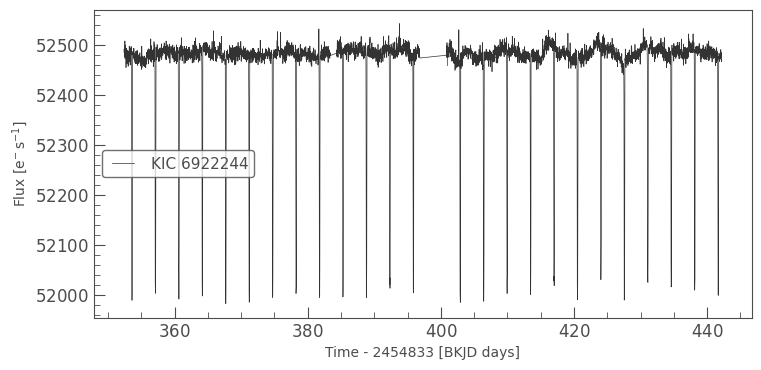

In [7]:
%matplotlib inline
klc.plot();

On this plot, the y-axis is flux in electrons per second. This unit may appear counterintutive, as flux is a measure of brightness. The CCD cameras measure an electrical charge, and so light is recorded as electrons, not photons as you might expect. On the x-axis we have time in Barycentric Kepler Julian Date (BKJD). In short, the x-axis values are days since the start of the *Kepler* mission. The repeating dips in brightness are transits, the effect of a planet orbiting Kepler-8 and passing between us and the star.

### Note

You can also download light curve FITS files from the archive by hand, store them on your local disk, and open them using the `lk.read(<filename>)` function. This function will return a `KeplerLightCurve` object just as in the above example. You can find out where Lightkurve stored a light curve file using the `filename` attribute:

In [8]:
klc.filename

'/Users/chedges/.lightkurve/cache/mastDownload/Kepler/kplr006922244_lc_Q111111111111111111/kplr006922244-2010078095331_llc.fits'

## 3. The SAP and PDCSAP Light Curves

As you can see in the Table above, there are two different types of flux stored in the `KeplerLightCurve` object. These correspond to different levels of data treatment performed for this star by NASA's [*Kepler* Data Processing Pipeline](https://github.com/nasa/kepler-pipeline/): the simple aperture photometry (SAP) flux, and the presearch data conditioning SAP (PDCSAP) flux. 

By default, a `KeplerLightCurve` will set the PDCSAP flux to its `.flux` property. 

To compare the PDCSAP and the SAP flux, we can use the `column` keyword while plotting.

**Note**: alternatively, you can replace the `flux` column with the `sap_flux` column by using `klc.flux = klc['sap_flux']`.


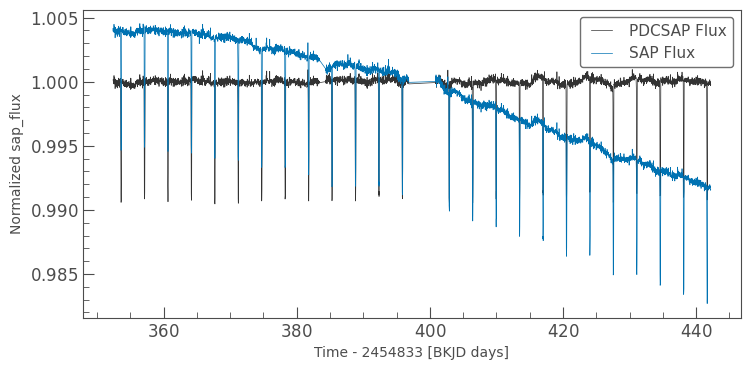

In [9]:
ax = klc.plot(column='pdcsap_flux', label='PDCSAP Flux', normalize=True)
klc.plot(column='sap_flux', label='SAP Flux', normalize=True, ax=ax);

In brief:

* The SAP light curve is calculated by summing together the brightness of pixels that fall within an aperture set by the *Kepler* mission. This is often referred to as the *optimal aperture*, but in spite of its name can sometimes be improved upon! Because the SAP light curve is a sum of the brightness in chosen pixels, it is still subject to systematic artifacts of the mission.

* The PDCSAP light curve is subject to more treatment than the SAP light curve, and is specifically intended for detecting planets. The PDCSAP pipeline attempts to remove systematic artifacts while keeping planetary transits intact.

Looking at the figure we made above, you can see that the SAP light curve has a long-term change in brightness that has been removed in the PDCSAP light curve, while keeping the transits at the same depth. For most inspections, a PDCSAP light curve is what you want to use, but when looking at astronomical phenomena that aren't planets (for example, long-term variability), the SAP flux may be preferred.

For now, let's continue to use the PDCSAP flux only. Because this is the default `.flux` property of our light curve object, we don't need to change anything.

### Note

The `plot()` methods in Lightkurve always return a [Matplotlib](https://matplotlib.org/) object. This is useful because it lets us manipulate the plot using standard Matplotlib functions. For example, we can set the title as follows:

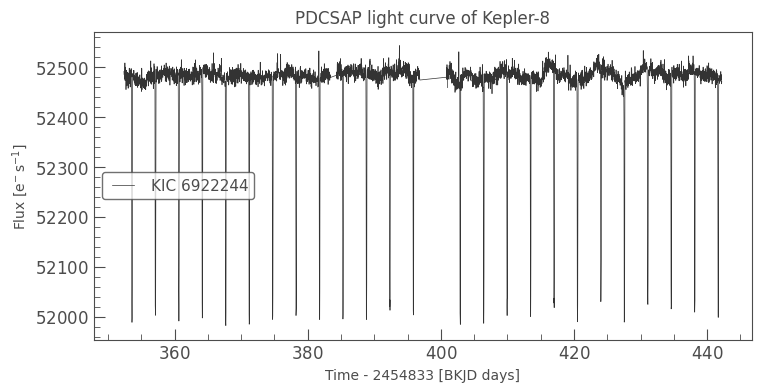

In [10]:
ax = klc.plot() 
ax.set_title("PDCSAP light curve of Kepler-8");

And the figure can be saved as follows:

In [11]:
ax.figure.savefig('demo-lightcurve.png')

## 4. Accessing the Metadata

When downloading data from MAST, that data usually comes in the format of a FITS file. These FITS files carry a wealth of metadata about the observation. When these are loaded in to Lightkurve to create a `KeplerLightCurve`, all of the metadata are stored in the `.meta` property of the object.

We can view these metadata by calling this property, as follows:

In [12]:
klc.meta

{'INHERIT': True,
 'EXTNAME': 'PRIMARY',
 'EXTVER': 1,
 'TELESCOP': 'Kepler',
 'INSTRUME': 'Kepler Photometer',
 'OBJECT': 'KIC 6922244',
 'KEPLERID': 6922244,
 'RADESYS': 'ICRS',
 'RA_OBJ': 281.28812,
 'DEC_OBJ': 42.45108,
 'EQUINOX': 2000.0,
 'EXPOSURE': 82.71685005,
 'TIMEREF': 'SOLARSYSTEM',
 'TASSIGN': 'SPACECRAFT',
 'TIMESYS': 'TDB',
 'BJDREFI': 2454833,
 'BJDREFF': 0.0,
 'TIMEUNIT': 'd',
 'TELAPSE': 89.84761299,
 'LIVETIME': 82.71685005,
 'TSTART': 352.36610827,
 'TSTOP': 442.21372126,
 'LC_START': 55184.87773552,
 'LC_END': 55274.70383812,
 'DEADC': 0.92063492,
 'TIMEPIXR': 0.5,
 'TIERRELA': 5.78e-07,
 'TIERABSO': <astropy.io.fits.card.Undefined at 0x2898efbe0>,
 'INT_TIME': 6.01980290327,
 'READTIME': 0.518948526144,
 'FRAMETIM': 6.538751429414,
 'NUM_FRM': 270,
 'TIMEDEL': 0.02043359821692,
 'DATE-OBS': '2009-12-19T20:49:13.619Z',
 'DATE-END': '2010-03-19T17:08:14.343Z',
 'BACKAPP': True,
 'DEADAPP': True,
 'VIGNAPP': True,
 'GAIN': 115.49,
 'READNOIS': 83.014212,
 'NREADOUT'

As you can see, there is a lot here if you don't know what you are looking for! These metadata don't just include information about the observations, but also data from the [*Kepler* Input Catalogue](https://ui.adsabs.harvard.edu/abs/2011AJ....142..112B/abstract) (KIC) used to select observing targets, such as their magnitudes and temperature.

The `.meta` property is a [Python dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries), which has some convenient features. For example, we can retrieve the value of an individual keyword as follows:

In [13]:
klc.meta['QUARTER']

4

Alternatively, we can use the `.get()` method, which accounts for queries that aren't in the dictionary.

In [14]:
klc.meta.get('MISSION')

'Kepler'

A feature of the `KeplerLightCurve` object is that the metadata can also be accessed via user-friendly object properties for convenience. For example, the *Kepler* Quarter number is directly accessible via the `quarter` property:

In [15]:
klc.quarter

4

## 5. Understanding the Data Arrays and Units

As we saw above, the `KeplerLightCurve` object is a table that contains many arrays other than the PDCSAP and SAP fluxes. Detailed information on each of these can be found in the [*Kepler* Archive Manual](http://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/archive_manual.pdf), *Section 2.3.1. Light Curve Files*.

The first six columns appear in all `KeplerLightCurve` objects, and contain the most commonly used information. These are:

- `time`: the time measurements at each cadence.
- `flux`: the flux of the target star at each time measurement. This is populated with PDCSAP flux by default.
- `flux_err`: the statistical uncertainty on each flux data point.
- `quality`: information on the data quality at each time measurement.
- `centroid_col` & `centroid_row`: the position of the target star on the CCD at each observation. This changes over time due to, for example, small jitters of the spacecraft.


The remaining columns are more detailed information on the observation. Some of these are duplicated in the first five columns described above:

- `timecorr`: correction values that allow users to revert back to non-barycentric timestamps.
- `cadenceno`: these are mission-specific identifiers of each exposure.
- `sap_flux` & `sap_flux_err`: the SAP flux and associated error.
- `sap_bkg` & `sap_bkg_err`: the calculated background (and associated error) inside the aperture used to calculate the SAP flux.
- `pdcsap_flux` & `pdcsap_flux_err`: the PDCSAP flux and associated error. Duplicated by default in `flux` and `flux_err`.
- `sap_quality`: information on the data quality at each time measurement. Duplicated in `quality`.
- `psf_centr1` & `psf_centr2` (and errors): the column and row centroid positions of a PSF model fit to the target star.
- `mom_centr1` & `mom_centr2` (and errors): the column and row centroid positions of the target star, weighted by flux. Duplicated in `centroid_col` and `centroid_row` respectively.
- `pos_corr1` & `pos_corr2`: the column and row components of the calculated image motion.

These columns can be accessed as properties of the `KeplerLightCurve` , for example, as follows:

In [16]:
klc.sap_bkg

<MaskedQuantity [1672.2699, 1669.84  , 1673.1306, ..., 1498.2946,
                 1498.7802, 1497.7747] electron / s>

The unit information of the arrays are stored using Astropy's [`astropy.units`](https://docs.astropy.org/en/stable/units/) module, which means that they are an Astropy [`Quantity`](https://docs.astropy.org/en/stable/api/astropy.units.Quantity.html#astropy.units.Quantity) object. We can view the units as follows:

In [17]:
print(f'Centroid column unit: {klc.centroid_col.unit}')
print(f'Flux unit: {klc.flux.unit}')

Centroid column unit: pix
Flux unit: electron / s


You can access the data in the form of a standard NumPy array using the `value` attribute:

In [18]:
klc.centroid_col.value

MaskedNDArray([682.69124789, 682.69084371, 682.6903808 , ...,
               682.49103683, 682.49113696, 682.49069432])

We can also plot the data using the `KeplerLightCurve`'s `plot()` method by passing a `column` keyword argument:

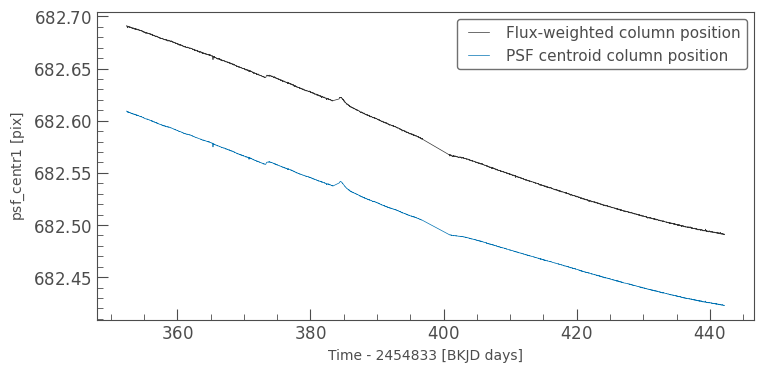

In [19]:
ax = klc.plot(column='mom_centr1', label='Flux-weighted column position')
klc.plot(ax=ax, column='psf_centr1', label='PSF centroid column position');

Finally, the `.time` property is a little different. Instead of an Astropy `Quantity` object, it is an Astropy [`Time`](https://docs.astropy.org/en/stable/time/) object, and has some additional time scale and format information.

In [20]:
klc.time

<Time object: scale='tdb' format='bkjd' value=[352.37632485 352.39675805 352.43762445 ... 442.16263546 442.18306983
 442.2035041 ]>

In [21]:
print(f'Time scale: {klc.time.scale}')
print(f'Time format: {klc.time.format}')

Time scale: tdb
Time format: bkjd


Here, the *time format* is the unit of time, in this case Barycentric Kepler Julian Date (BKJD). The *time scale* indicates how the time is measured, in this case by taking the Barycentric Dynamical Time (TDB). This detailed information may be important when comparing observations of a periodic event (such as a planet transit) with observations made with other telescopes on Earth.

## Exercises

Some stars, such as Kepler-10, have been observed both with *Kepler* and *TESS*. In this exercise, download and plot the *TESS* PDCSAP flux only. You can do this by either selecting it from the `SearchResult` returned by [`search_lightcurve()`](https://docs.lightkurve.org/reference/api/lightkurve.search_lightcurve.html?highlight=search_lightcurve) or by using the `mission` keyword argument when searching.

In [22]:
#search_result = lk.search_lightcurvefile(...)

In [23]:
# Solution:
search_result = lk.search_lightcurve('Kepler-10', mission='TESS')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 14,2019,SPOC,120,377780790,0.0
1,TESS Sector 14,2019,TESS-SPOC,1800,377780790,0.0
2,TESS Sector 14,2019,QLP,1800,377780790,0.0
3,TESS Sector 14,2019,TASOC,120,377780790,0.0
4,TESS Sector 14,2019,TASOC,1800,377780790,0.0
5,TESS Sector 14,2019,TASOC,1800,377780790,0.0
...,...,...,...,...,...,...
23,TESS Sector 41,2021,QLP,600,377780790,0.0
24,TESS Sector 53,2022,SPOC,20,377780790,0.0


/Users/chedges/repos/lightkurve/src/lightkurve/search.py:414: LightkurveWarning: Warning: 30 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


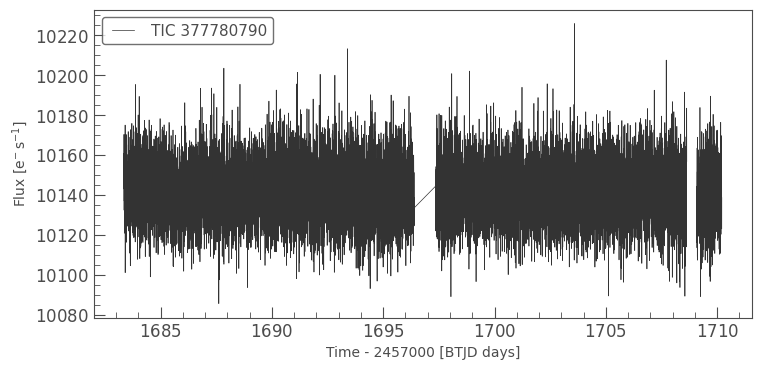

In [24]:
search_result.download().plot();

## About this Notebook

**Authors:** Oliver Hall (oliver.hall@esa.int), Geert Barentsen

**Updated On**: 2020-08-31

## Citing Lightkurve and Astropy

If you use `lightkurve` or `astropy` for published research, please cite the authors. Click the buttons below to copy BibTeX entries to your clipboard. 

In [25]:
lk.show_citation_instructions()

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>
